# Timeseries of RKW parameters

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# trick to read function in a separate file
import sys
sys.path.append('/glade/u/home/rberrios/python/PRECIP/')
from defineColormaps import *

%matplotlib inline

Define function that winds a cold pool location.

In [2]:
from scipy.interpolate import RegularGridInterpolator

def calculate_centroid_horizontal_gradient(thetaRho):
    """
    Calculates the horizontal gradient of an xarray DataArray with
    'latitude' and 'longitude' coordinates and finds the location
    of the maximum gradient magnitude.

    Args:
        thetaRho (xr.DataArray): An xarray DataArray with 'latitude' and
                                  'longitude' as coordinates.

    Returns:
        tuple: A tuple containing:
            - gradient_magnitude (xr.DataArray): The magnitude of the
              horizontal gradient.
            - lon_max (float): The longitude of the maximum gradient magnitude.
            - lat_max (float): The latitude of the maximum gradient magnitude.
    """

    # Smooth out theta_rho first
    # Define a window size for a 2D rolling mean
    window_size = 5 # Must be an odd number for centering
    
    # Apply a rolling mean (boxcar filter)
    thetaRho_rolling_mean = thetaRho.rolling(
        latitude=window_size,
        longitude=window_size,
        center=True,
        min_periods=1 # Handle edges
    ).mean()

    # Calculate the gradient along the longitude dimension
    dthetaRho_dlon = thetaRho_rolling_mean.differentiate('longitude')

    # Calculate the gradient along the latitude dimension
    dthetaRho_dlat = thetaRho_rolling_mean.differentiate('latitude')

    # Calculate the magnitude of the horizontal gradient
    gradient_magnitude = np.sqrt(dthetaRho_dlon**2 + dthetaRho_dlat**2)

    # Put it back into a DataArray to keep the coordinates
    gradient_magnitude_da = xr.DataArray(
        gradient_magnitude,
        coords=thetaRho.coords,
        dims=thetaRho.dims,
        name='theta_gradient_magnitude'
    )


    # Keep only the strongest gradients (e.g., above the 98th percentile)
    threshold = gradient_magnitude_da.quantile(0.98, dim=...) # Ellipsis applies to all dims
    
    # Create a DataArray of the strong gradients, setting others to 0
    # The .where() method is perfect for this
    strong_gradient = gradient_magnitude_da.where(gradient_magnitude_da >= threshold, 0)

    # The total weight is the sum of all gradient magnitudes in our feature
    total_weight = strong_gradient.sum()
    
    # To get the x-centroid, we multiply the strong_gradient field by the x-coordinate
    # at every point, sum it up, and divide by the total weight.
    # Xarray's broadcasting makes the `strong_gradient * strong_gradient.x` part easy.
    centroid_x = (strong_gradient * strong_gradient.longitude).sum() / total_weight
    centroid_y = (strong_gradient * strong_gradient.latitude).sum() / total_weight
    
    print(f"Calculated Centroid of the leading edge:")
    print(f"  X-coordinate: {centroid_x.item():.2f} km")
    print(f"  Y-coordinate: {centroid_y.item():.2f} km")

    return gradient_magnitude, centroid_x, centroid_y

def vertical_cross_section_angled(ds, iLat, iLon, fLat, fLon, varName, 
                                  uzonal_var='uzonal_isobaric', umeridional_var='umeridional_isobaric', ndist=100,
                                 uMotion=0.0, vMotion=0.0):
    """
    Extracts a vertical cross-section of wind data along a straight line, returning an array.

    Args:
        ds (xarray.Dataset): The xarray dataset containing wind data.
        iLat (float): Latitude of the starting point.
        iLon (float): Longitude of the starting point.
        fLat (float): Latitude of the ending point.
        fLon (float): Longitude of the ending point.
        uzonal_var (str): Name of the zonal wind variable.
        umeridional_var (str): Name of the meridional wind variable.
        ndist (int): Number of grid points along the cross-section line.

    Returns:
        numpy.ndarray: An array of shape (ndist, nz) containing the parallel wind.
    """
    dist = np.sqrt((fLat - iLat)**2 + (fLon - iLon)**2)
    lat_points = np.linspace(iLat, fLat, ndist)
    lon_points = np.linspace(iLon, fLon, ndist)

    cross_section = ds.sel(latitude=slice(min(iLat, fLat), max(iLat, fLat)),
                           longitude=slice(min(iLon, fLon), max(iLon, fLon)))

    dlat = fLat - iLat
    dlon = fLon - iLon

    # read variable of interest
    if (varName == 'parallel_wind'):
        angle = np.arctan2(dlat, dlon)
    
        uzonal = cross_section[uzonal_var]
        umeridional = cross_section[umeridional_var]

        #subtract motion if given
        uzonal = uzonal - uMotion
        umeridional = umeridional - vMotion
    
        var = uzonal * np.cos(angle) + umeridional * np.sin(angle)
    elif (varName == 'thetaRho'):
        # density potential temperature to identify cold pools
        theta = cross_section['theta']
        qv = cross_section['qv']
        qc = cross_section['qc']
        qr = cross_section['qr']
        var = theta*(1.0 + (0.608*qv) - qc - qr)
    elif (varName == 'condensate'):
        var = cross_section['qc']+cross_section['qg']+cross_section['qs']+cross_section['qi']
    else:
        var = cross_section[varName]

    # define interpolation variable
    var_interp = np.zeros((var.shape[0],ndist))

    for z_index in range(var.shape[0]):
        # Interpolate using RegularGridInterpolator
        interp_func = RegularGridInterpolator((cross_section['longitude'].values, cross_section['latitude'].values),
                                             var[z_index,:].values.T,
                                             bounds_error=False, fill_value=None)

        # Create the interpolation points
        interp_points = np.array([lon_points, lat_points]).T

        var_interp[z_index, :] = interp_func(interp_points)

    da = xr.DataArray(var_interp, dims=[var.dims[0],'longitude'], coords=[var[var.dims[0]], lon_points])

    return da


Define basic parameters.

In [3]:
mainDir= '/glade/scratch/rberrios/2022-real-time-forecasts/'
mpasDir= '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/'
TODAY='20220912'
HH='12'
initTime = datetime.strptime(TODAY+HH, '%Y%m%d%H')

mpasStr='atl' 
domain = 'westAfrica'
varName = 'thetaRho'

Attempt to do this.

In [25]:
option = 'southernSquallNoon'

pbot = 950e2
if option == 'southernSquall':
    fhrvec = np.arange(25.0,42,1.0)
    minLat = 9.0-2.0
    maxLat = 9.0+2.0
    minLon = -12.0
    maxLon = -5.0
    pLabel = '(a)'
    outputDir = '%s%s%s_noomld/intrp_output/'%(mpasDir,TODAY,HH)
    crossingTime = 33
    ptop = 650e2
elif (option == 'southernSquallNoon'):
    fhrvec = np.arange(15.0,37,1.0)
    minLat = 9.0-2.0
    maxLat = 9.0+2.0
    minLon = -12.0
    maxLon = -5.0
    pLabel = '(c)'
    crossingTime = 29
    ptop = 625e2
    outputDir = '%s%s%s_noomld_perpnoon/intrp_output/'%(mpasDir,TODAY,HH)
elif (option == 'northernSquall'):
    fhrvec = np.arange(33.0,50.0,1.0)
    minLat = 13.0-2.0
    maxLat = 13.0+2.0
    minLon = -19.0
    maxLon = -10.0
    pLabel = '(b)'
    crossingTime = 46
    ptop = 550e2
    outputDir = '%s%s%s_noomld/intrp_output/'%(mpasDir,TODAY,HH)

2022-09-13 03:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_03:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-6.68770139)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.29512687)
Coordinates:
    quantile  float64 8B 0.99


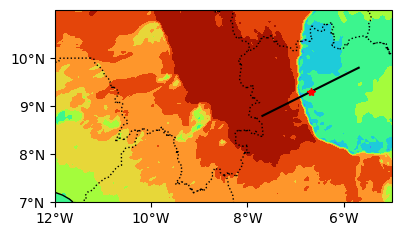

shear magnitude: -10.128307
cold pool strength: 26.528871
c/du: 2.619280
2022-09-13 04:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_04:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-7.37188376)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.05274225)
Coordinates:
    quantile  float64 8B 0.99


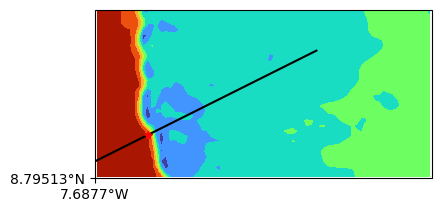

shear magnitude: -10.438167
cold pool strength: 27.116107
c/du: 2.597784
2022-09-13 05:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_05:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-7.82206268)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.98500061)
Coordinates:
    quantile  float64 8B 0.99


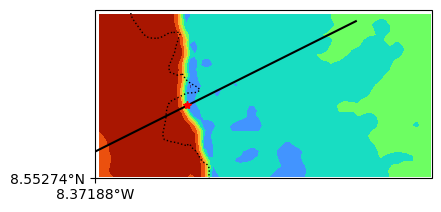

shear magnitude: -18.471327
cold pool strength: 25.392356
c/du: 1.374690
2022-09-13 06:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_06:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-8.28076566)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.20854925)
Coordinates:
    quantile  float64 8B 0.99


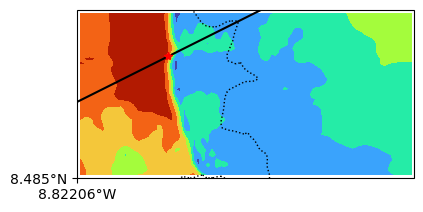

shear magnitude: -15.923341
cold pool strength: 24.435486
c/du: 1.534570
2022-09-13 07:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_07:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-8.65942644)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.45728585)
Coordinates:
    quantile  float64 8B 0.99


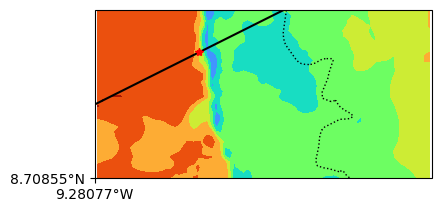

shear magnitude: -13.571885
cold pool strength: 23.076178
c/du: 1.700293
2022-09-13 08:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_08:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-8.9155426)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.33750057)
Coordinates:
    quantile  float64 8B 0.99


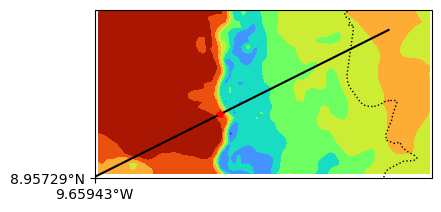

shear magnitude: -15.629459
cold pool strength: 21.234670
c/du: 1.358631
2022-09-13 09:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_09:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-9.22773743)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.41470696)
Coordinates:
    quantile  float64 8B 0.99


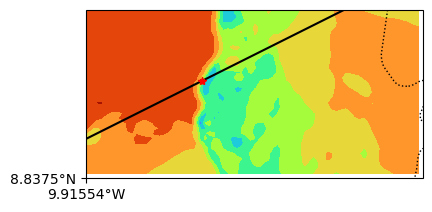

shear magnitude: -15.287421
cold pool strength: 20.694291
c/du: 1.353681
2022-09-13 10:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_10:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-9.53037781)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.57540039)
Coordinates:
    quantile  float64 8B 0.99


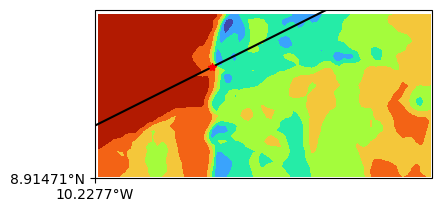

shear magnitude: -16.013166
cold pool strength: 24.254562
c/du: 1.514664
2022-09-13 11:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_11:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-9.90402222)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.91500092)
Coordinates:
    quantile  float64 8B 0.99


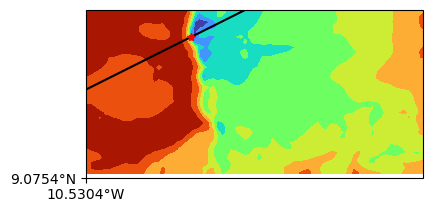

shear magnitude: -17.586742
cold pool strength: 27.456553
c/du: 1.561207
2022-09-13 12:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_12:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-10.38331068)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.77229845)
Coordinates:
    quantile  float64 8B 0.99


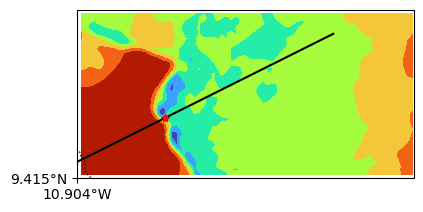

shear magnitude: -18.139349
cold pool strength: 25.698793
c/du: 1.416743
2022-09-13 13:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_13:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-10.86787415)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.56000061)
Coordinates:
    quantile  float64 8B 0.99


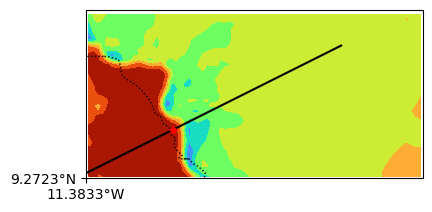

shear magnitude: -19.759989
cold pool strength: 26.315755
c/du: 1.331770
2022-09-13 14:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_14:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-11.49604014)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.52500049)
Coordinates:
    quantile  float64 8B 0.99


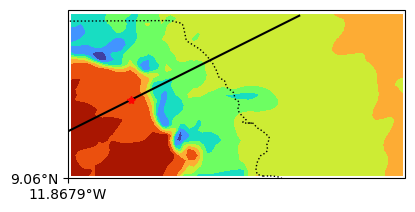

shear magnitude: -15.084840
cold pool strength: 20.888269
c/du: 1.384719
2022-09-13 15:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_15:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-12.19530334)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.37200114)
Coordinates:
    quantile  float64 8B 0.99


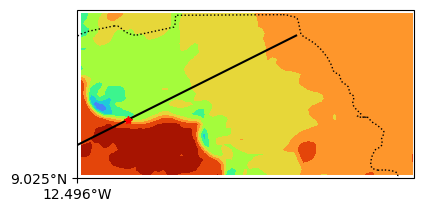

shear magnitude: -16.885686
cold pool strength: 21.925741
c/du: 1.298481
2022-09-13 16:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_16:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-12.61349382)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.1070704)
Coordinates:
    quantile  float64 8B 0.99


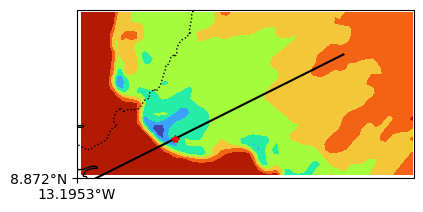

shear magnitude: -16.140388
cold pool strength: 25.540265
c/du: 1.582382
2022-09-13 17:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_17:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-13.2190317)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(9.01269296)
Coordinates:
    quantile  float64 8B 0.99


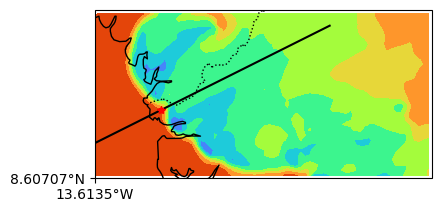

shear magnitude: -13.905635
cold pool strength: 26.287781
c/du: 1.890441
2022-09-13 18:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_18:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-13.6270752)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.83887113)
Coordinates:
    quantile  float64 8B 0.99


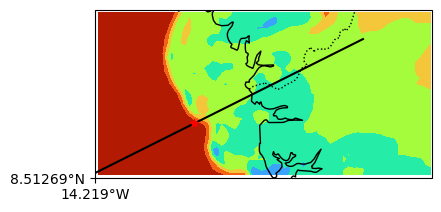

shear magnitude: -14.351224
cold pool strength: 27.700522
c/du: 1.930185
2022-09-13 19:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_19:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-13.92785196)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.63117712)
Coordinates:
    quantile  float64 8B 0.99


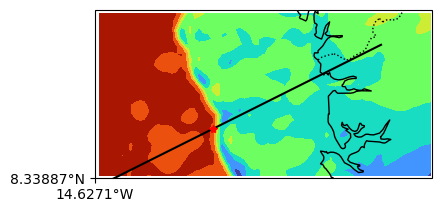

shear magnitude: -7.014746
cold pool strength: 20.347871
c/du: 2.900728
2022-09-13 20:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_20:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-14.26906913)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.57700021)
Coordinates:
    quantile  float64 8B 0.99


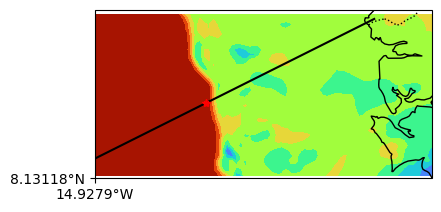

shear magnitude: -5.847072
cold pool strength: 15.239979
c/du: 2.606429
2022-09-13 21:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_21:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-14.50227217)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.35590894)
Coordinates:
    quantile  float64 8B 0.99


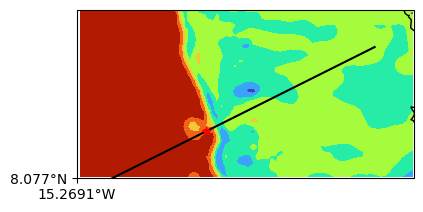

shear magnitude: -4.048338
cold pool strength: 14.187775
c/du: 3.504592
2022-09-13 22:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_22:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-14.72768849)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.191552)
Coordinates:
    quantile  float64 8B 0.99


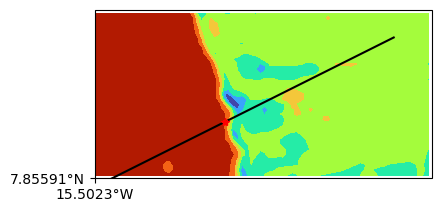

shear magnitude: -2.982687
cold pool strength: 14.038241
c/du: 4.706575
2022-09-13 23:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_23:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-15.14097676)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.58078967)
Coordinates:
    quantile  float64 8B 0.99


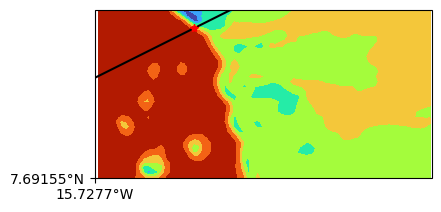

shear magnitude: -4.040752
cold pool strength: 13.708509
c/du: 3.392564
2022-09-14 00:00:00
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-14_00:00_latlon_westAfrica.nc
<xarray.DataArray ()> Size: 8B
array(-15.74620342)
Coordinates:
    quantile  float64 8B 0.99 <xarray.DataArray ()> Size: 8B
array(8.69250011)
Coordinates:
    quantile  float64 8B 0.99


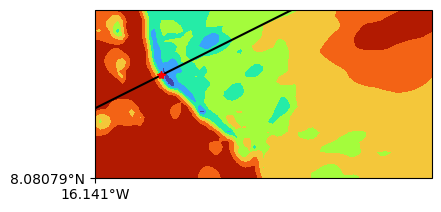

shear magnitude: -4.671380
cold pool strength: 12.745265
c/du: 2.728373


In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# set additional variables
lat_interval = 1.0
lon_interval = 2.0
num_rows = 2
num_cols = 2

# initiate lists to hold values
cpInt = []
shear = []
time = []

for fhr in fhrvec:
    
    fig = plt.figure(figsize=(10, 5 * num_rows))  # Adjust figure size as needed
    gs = fig.add_gridspec(num_rows, num_cols, hspace=0.3, wspace=0.3) # Create grid specification
    
    # Add the map panel to the first column
    ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ax_map.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree()) # Set zoomed-in extent
    ax_map.add_feature(cfeature.COASTLINE)
    ax_map.add_feature(cfeature.BORDERS, linestyle=':')
    # Add Latitudes
    ax_map.set_yticks(np.arange(minLat, maxLat, lat_interval), crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax_map.yaxis.set_major_formatter(lat_formatter)
    # Add Longitudes
    ax_map.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax_map.xaxis.set_major_formatter(lon_formatter)


    validTime = initTime+timedelta(hours=(fhr))
    print(validTime)
    time.append(validTime)
    validTimeFormatted = datetime.strftime(initTime+timedelta(hours=(fhr)), '%Y-%m-%d_%H:%M')
    fname='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeFormatted,domain)
    print(fname)
    ds = xr.open_dataset(fname).squeeze()
    
    # calculate density potential temperature to identify cold pools
    theta = ds['theta'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qv = ds['qv'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qc = ds['qc'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    qr = ds['qr'].isel(nVertLevels=0).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon))
    thetaRhoSurf = theta*(1.0 + (0.608*qv) - qc - qr)

    theta_threshold = 300.0

    # Smooth out theta_rho first
    # Define a window size for a 2D rolling mean
    window_size = 5 # Must be an odd number for centering
    
    # Apply a rolling mean (boxcar filter)
    thetaRho_rolling_mean = thetaRhoSurf.rolling(
        latitude=window_size,
        longitude=window_size,
        center=True,
        min_periods=1 # Handle edges
    ).mean()

    # Calculate the gradient along the longitude dimension
    dthetaRho_dlon = thetaRho_rolling_mean.differentiate('longitude')

    # Calculate the gradient along the latitude dimension
    dthetaRho_dlat = thetaRho_rolling_mean.differentiate('latitude')

    # Calculate the magnitude of the horizontal gradient
    gradient_magnitude = np.sqrt(dthetaRho_dlon**2 + dthetaRho_dlat**2)

    # Put it back into a DataArray to keep the coordinates
    gradient_magnitude_da = xr.DataArray(
        gradient_magnitude,
        coords=thetaRhoSurf.coords,
        dims=thetaRhoSurf.dims,
        name='theta_gradient_magnitude'
    )

    # Keep only the strongest gradients (e.g., above the 98th percentile)
    threshold = gradient_magnitude_da.quantile(0.99, dim=...) # Ellipsis applies to all dims
    
    # Create a DataArray of the strong gradients, setting others to 0
    # The .where() method is perfect for this
    # strong_gradient = gradient_magnitude_da.where(gradient_magnitude_da >= threshold, 0)
    strong_gradient = gradient_magnitude >= threshold
    
    # # --- Using da_theta from the previous example ---
    
    # # 1. Define a robust threshold
    # # We assume 'ambient' is the high end and 'cold pool' is the low end.
    # theta_min = da_theta.min()
    # theta_max = da_theta.max() # Or a known ambient value
    # # A threshold halfway between the min and max is a good starting point
    # theta_threshold = theta_min + 0.5 * (theta_max - theta_min)
    
    # print(f"Min Theta: {theta_min.item():.2f} K")
    # print(f"Max Theta: {theta_max.item():.2f} K")
    # print(f"Using Threshold: {theta_threshold.item():.2f} K")
    
    
    
    # # 2. Create a binary mask of the cold pool
    # cold_pool_mask = thetaRhoSurf <= theta_threshold
    
    # 3. Find the boundary of the mask
    # find_boundaries returns a boolean array where True is the boundary.
    # mode='outer' finds the outer edge, which is exactly what we want.
    leading_edge_mask = find_boundaries(strong_gradient, mode='outer')
    
    # For analysis, get the coordinates of the leading edge points
    # --- THE FIX IS HERE ---
    # Instead of using .where(), we find the indices of the True values in the mask
    y_indices, x_indices = np.where(leading_edge_mask)
    
    # Now, use these integer indices to get the actual coordinate values
    # This guarantees edge_x_coords and edge_y_coords will have the same size
    edge_x_coords = thetaRhoSurf.longitude.values[x_indices]
    edge_y_coords = thetaRhoSurf.latitude.values[y_indices]
    # --- END OF FIX ---

    #centroid
    # The total weight is the sum of all gradient magnitudes in our feature
    total_weight = leading_edge_mask.sum()
    
    # To get the x-centroid, we multiply the strong_gradient field by the x-coordinate
    # at every point, sum it up, and divide by the total weight.
    # Xarray's broadcasting makes the `strong_gradient * strong_gradient.x` part easy.
    centLon = (leading_edge_mask * leading_edge_mask.longitude).sum() / total_weight
    centLat = (leading_edge_mask * leading_edge_mask.latitude).sum() / total_weight    
    
    # re-define minLat, maxLat, etc based on location of the cold pool
    if (option == 'northernSquall'):
        minLat = centLat+0.5
        maxLat = centLat-0.5
        uMotion = -17.7
        vMotion = 6.6
    else:
        minLat = centLat-0.5
        maxLat = centLat+0.5
        uMotion = -15.2
        vMotion = 2.2
    minLon = centLon-1.0
    maxLon = centLon+1.0

    print(centLon, centLat)
    # lat1 = centroid_y-0.5
    # lat2 = centroid_y+0.5
    # lon1 = centroid_x-1.0
    # lon2 = centroid_x+1.0
    
    # plot
    [X, Y] = np.meshgrid(thetaRhoSurf.longitude, thetaRhoSurf.latitude)
    ax_map.contourf(X,Y,thetaRhoSurf, cmap='turbo')#, levels = np.arange(290, 315, 1))
    ax_map.plot([minLon, maxLon], [minLat, maxLat], color='k', transform=ccrs.PlateCarree())
    ax_map.plot(centLon, centLat, '*r')
    plt.show()

    # # # Extract the cross-section
    parallel_wind = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'parallel_wind')
    field = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'thetaRho')

    # now read vertical grid
    fname='/glade/work/rberrios/MPAS/cpex-cv/%s%s/latlon.nc'%(TODAY,HH)
    ds = xr.open_dataset(fname).squeeze()
    z_stag = vertical_cross_section_angled(ds, minLat, minLon, maxLat, maxLon, 'zgrid')
    del(ds)
    # unstagger
    z_unstag = 0.5*(z_stag[1:,:].values+z_stag[:-1,:].values)*0.001 # in km
    
    # read_plot_cross_section_along_latitude(TODAY,HH,fhr,varName,minLat,maxLat,minLon,maxLon)

    # done reading, now we calculate
    # calculate line-perpendicular shear
    ushear = parallel_wind.sel(longitude=centLon-0.5,u_iso_levels=ptop,method='nearest')-\
            parallel_wind.sel(longitude=centLon-0.5,u_iso_levels=pbot,method='nearest')
    print('shear magnitude: %f'%(ushear.values))
    
    # check buoyancy
    refProf = field.sel(longitude=centLon-0.5, method='nearest')
    buoyancy = 9.81*((field-refProf)/refProf)
    # i don't think we should only consider negative buoyancy, or yes... yes
    buoyancy = buoyancy.where(buoyancy<0.0,other=0.0)
    c = np.sqrt(-2.*np.trapz(buoyancy[0:24,:],z_unstag[0:24,:]*1.0e3,axis=0))
    print('cold pool strength: %f'%c.max())
    print('c/du: %f'%(c.max()/np.fabs(ushear.values)))

    cpInt.append(c.max())
    shear.append(np.fabs(ushear))

    # advance... let's make sure minLat < maxLat for data reading
    if (minLat > maxLat):
        temp = minLat
        minLat = maxLat
        maxLat = temp

    # advance
    # centLon = centLon + uMotion*(3600.0/111.0e3)
    # centLat = centLat + vMotion*(3600.0/111.0e3)

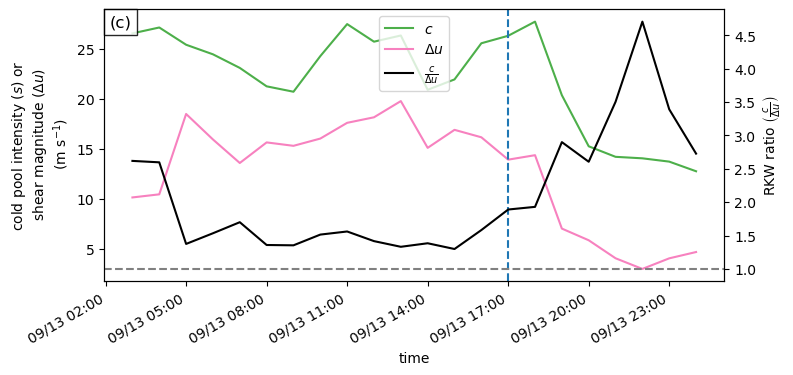

In [26]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(time,cpInt,label='$c$',color='#4daf4a')
ax1.plot(time,shear,label=r'$\Delta u$',color='#f781bf')
ax2 = ax1.twinx()
ax2.plot(time,np.array(cpInt)/np.array(shear),'k',label=r'$\frac{c}{\Delta u}$')
# add line at c/du = 1
ax2.axhline(y=1.0, color='gray', linestyle='dashed')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center')

# add axis labels
ax1.set(ylabel='cold pool intensity ($s$) or\n shear magnitude ($\Delta u$)\n (m s$^{-1}$)')
ax2.set(ylabel=r'RKW ratio $\left(\frac{c}{\Delta u}\right)$')

# add vertical line when the squall line exits the coast
validTime = initTime+timedelta(hours=crossingTime)
ax1.axvline(x=validTime, linestyle='dashed')

# Define the interval for the x-axis tick labels (every 3 h)
interval = timedelta(hours=3)
ax1.xaxis.set_major_locator(
    mdates.HourLocator(interval=3)
)  # Or mdates.SecondLocator(interval=600)

# Format the date/time display on the x-axis
date_format = mdates.DateFormatter("%m/%d %H:%M")  # Display hours and minutes
ax1.xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()  # Rotate date labels for better readability

# add panel label
ax1.text(0.009, 0.98, pLabel,
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax1.transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

if (option == 'southernSquallNoon'):
    ax1.set_xlabel('time')

plt.savefig(f'./Figures/{option}_rkw.jpeg',bbox_inches='tight',dpi=300)